In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torchvision
from torchvision import models
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.transforms as standard_transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform, color
import numpy as np
import random
import math
import glob
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Объявление классов и функций

In [ ]:
# Класс применяющий идентичные трансформации для входных изображений
class PairedDataAugmentation:

  def __init__(
      self,
      img_size,
      random_hflip=False,
      random_vflip=False,
      random_rot=False,
      random_crop=False,
      random_brightness=False,
      random_gamma=False,
      random_saturation=False,
      random_perspective=False
  ):
    self.img_size = img_size
    self.random_hflip = random_hflip
    self.random_vflip = random_vflip
    self.random_rot = random_rot
    self.random_crop = random_crop
    self.random_brightness = random_brightness
    self.random_gamma = random_gamma
    self.random_saturation = random_saturation
    self.random_perspective = random_perspective

  def transform(self, img1, img2):

    # Преобразуем в экземпляр PIL и решейпим
    img1 = TF.to_pil_image(img1)
    img1 = TF.resize(img1, [self.img_size, self.img_size], interpolation=3)
    img2 = TF.to_pil_image(img2)
    img2 = TF.resize(img2, [self.img_size, self.img_size], interpolation=3)

    # Если надо симметрично отрадаем по вретикали
    if self.random_hflip and random.random() > 0.5:
      img1 = TF.hflip(img1)
      img2 = TF.hflip(img2)

    # Если надо симметрично отрадаем по горизонтали
    if self.random_vflip and random.random() > 0.5:
      img1 = TF.vflip(img1)
      img2 = TF.vflip(img2)

    # Если надо повоорачиваем на случайный угол
    if self.random_rot and random.random() > 0.5:
      rot_angle = int(np.random.randint(0, 10))
      img1 = TF.rotate(img1, rot_angle)
      img2 = TF.rotate(img2, rot_angle)

    # Если надо изменяем перспективу у изображения
    if self.random_perspective and random.random() > 0.3:
      transform_var = int(np.random.uniform(4))
      startpoints = startpoints_set[transform_var]
      endpoints = endpoints_set[transform_var]
      img1 = TF.perspective(img1, startpoints=startpoints, endpoints=endpoints, fill=255)
      img2 = TF.perspective(img2, startpoints=startpoints, endpoints=endpoints, fill=255)

    # Если надо случайно кропим изображение
    if self.random_crop and random.random() > 0.5:
      i, j, h, w = transforms.RandomResizedCrop(size=self.img_size).get_params(img=img1,
                                                                               scale=(0.7, 1.3),
                                                                               ratio=(0.9, 1.1))
      img1 = TF.resized_crop(img1, i, j, h, w, size=(self.img_size, self.img_size))
      img2 = TF.resized_crop(img2, i, j, h, w, size=(self.img_size, self.img_size))

    # Если надо изменяем цветовую яркость, гамму, насыщенность только у фото
    if self.random_brightness and random.random() > 0.5:
      img1 = TF.adjust_brightness(img1, brightness_factor=random.uniform(0.5, 1.5))

    if self.random_gamma and random.random() > 0.5:
      img1 = TF.adjust_gamma(img1, gamma=random.uniform(0.5, 1.5))

    if self.random_saturation and random.random() > 0.5:
      img1 = TF.adjust_saturation(img1, saturation_factor=random.uniform(0.5, 1.5))

    # Преобразуем все в тензоты пайторча
    img1 = TF.to_tensor(img1)
    img2 = TF.to_tensor(img2)

    return img1, img2


class CustomDataset(Dataset):

  def __init__(self, root_dir, img_size, is_train=True):
    self.root_dir = root_dir
    self.img_size = img_size
    # Задаем преобразования для тренировочного и проверочного датасета
    if is_train:
      self.img_dirs = glob.glob(os.path.join(self.root_dir, 'data/train', '*.png'))
      self.augm = PairedDataAugmentation(
          img_size=self.img_size,
          random_hflip=True,
          random_crop=True,
          random_brightness=True,
          random_gamma=True,
          random_saturation=True,
          random_perspective=True
      )
    else:
      self.img_dirs = glob.glob(os.path.join(self.root_dir, 'data/test', '*.png'))
      self.augm = PairedDataAugmentation(
          img_size = self.img_size
      )

  def __len__(self):
    return len(self.img_dirs)

  def __getitem__(self, idx):

    if torch.is_tensor(idx):
      idx = idx.tolist()

    # Считываем изображение
    img = cv2.imread(self.img_dirs[idx], cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, c = img.shape

    # Разделяем фото и скетч
    img_1 = img[:,:w//2,:]
    img_2 = img[:,w//2:,:]

    # Препроцессинг
    img_2 = cv2.cvtColor(img_2, cv2.COLOR_RGB2GRAY)
    img_1, img_2 = self.augm.transform(img_1, img_2)

    data = {'I': img_1, 'M':img_2}

    return data

In [ ]:
class REBNCONV(nn.Module):
  def __init__(self, in_ch=3, out_ch=3, dirate=1):
    super(REBNCONV, self).__init__()

    self.conv_s1 = nn.Conv2d(in_ch, out_ch, 3, padding=1*dirate, dilation=1*dirate)
    self.bn_s1 = nn.BatchNorm2d(out_ch)
    self.relu_s1 = nn.ReLU(inplace=True)

  def forward(self, x):
    x_in = x
    x_out = self.relu_s1(self.bn_s1(self.conv_s1(x_in)))

    return x_out



def _upsample_like(src, tar):
  size = tar.shape[2:]
  src = torch.nn.functional.interpolate(src, size, mode='bilinear', align_corners=False)
  return src



class RSU7(nn.Module):

  def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
    super(RSU7, self).__init__()

    self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

    self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
    self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

    self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=1)
    self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

    self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=1)
    self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

    self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=1)
    self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

    self.rebnconv5 = REBNCONV(mid_ch, mid_ch, dirate=1)
    self.pool5 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

    self.rebnconv6 = REBNCONV(mid_ch, mid_ch, dirate=1)

    self.rebnconv7 = REBNCONV(mid_ch, mid_ch, dirate=2)

    self.rebnconv6d = REBNCONV(2*mid_ch, mid_ch, dirate=1)
    self.rebnconv5d = REBNCONV(2*mid_ch, mid_ch, dirate=1)
    self.rebnconv4d = REBNCONV(2*mid_ch, mid_ch, dirate=1)
    self.rebnconv3d = REBNCONV(2*mid_ch, mid_ch, dirate=1)
    self.rebnconv2d = REBNCONV(2*mid_ch, mid_ch, dirate=1)
    self.rebnconv1d = REBNCONV(2*mid_ch, out_ch, dirate=1)
    
  def forward(self, x):

    x_in = x

    x_in = self.rebnconvin(x_in)

    x_1 = self.rebnconv1(x_in)
    x = self.pool1(x_1)

    x_2 = self.rebnconv2(x)
    x = self.pool2(x_2)

    x_3 = self.rebnconv3(x)
    x = self.pool3(x_3)

    x_4 = self.rebnconv4(x)
    x = self.pool4(x_4)

    x_5 = self.rebnconv5(x)
    x = self.pool5(x_5)

    x_6 = self.rebnconv6(x)

    x_7 = self.rebnconv7(x_6)

    x_6d = self.rebnconv6d(torch.cat((x_7, x_6), 1))
    x_6_up = _upsample_like(x_6d, x_5)

    x_5d = self.rebnconv5d(torch.cat((x_6_up, x_5), 1))
    x_5_up = _upsample_like(x_5d, x_4)

    x_4d = self.rebnconv4d(torch.cat((x_5_up, x_4), 1))
    x_4_up = _upsample_like(x_4d, x_3)

    x_3d = self.rebnconv3d(torch.cat((x_4_up, x_3), 1))
    x_3_up = _upsample_like(x_3d, x_2)

    x_2d = self.rebnconv2d(torch.cat((x_3_up, x_2), 1))
    x_2_up = _upsample_like(x_2d, x_1)

    x_1d = self.rebnconv1d(torch.cat((x_2_up, x_1), 1))

    return x_1d + x_in



class RSU6(nn.Module):

  def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
    super(RSU6, self).__init__()

    self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

    self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
    self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

    self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=1)
    self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

    self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=1)
    self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

    self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=1)
    self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

    self.rebnconv5 = REBNCONV(mid_ch, mid_ch, dirate=1)

    self.rebnconv6 = REBNCONV(mid_ch, mid_ch, dirate=2)

    self.rebnconv5d = REBNCONV(2*mid_ch, mid_ch, dirate=1)
    self.rebnconv4d = REBNCONV(2*mid_ch, mid_ch, dirate=1)
    self.rebnconv3d = REBNCONV(2*mid_ch, mid_ch, dirate=1)
    self.rebnconv2d = REBNCONV(2*mid_ch, mid_ch, dirate=1)
    self.rebnconv1d = REBNCONV(2*mid_ch, out_ch, dirate=1)
    
  def forward(self, x):

    x_in = x

    x_in = self.rebnconvin(x_in)

    x_1 = self.rebnconv1(x_in)
    x = self.pool1(x_1)

    x_2 = self.rebnconv2(x)
    x = self.pool2(x_2)

    x_3 = self.rebnconv3(x)
    x = self.pool3(x_3)

    x_4 = self.rebnconv4(x)
    x = self.pool4(x_4)

    x_5 = self.rebnconv5(x)

    x_6 = self.rebnconv6(x_5)

    x_5d = self.rebnconv5d(torch.cat((x_6, x_5), 1))
    x_5_up = _upsample_like(x_5d, x_4)

    x_4d = self.rebnconv4d(torch.cat((x_5_up, x_4), 1))
    x_4_up = _upsample_like(x_4d, x_3)

    x_3d = self.rebnconv3d(torch.cat((x_4_up, x_3), 1))
    x_3_up = _upsample_like(x_3d, x_2)

    x_2d = self.rebnconv2d(torch.cat((x_3_up, x_2), 1))
    x_2_up = _upsample_like(x_2d, x_1)

    x_1d = self.rebnconv1d(torch.cat((x_2_up, x_1), 1))

    return x_1d + x_in



class RSU5(nn.Module):

  def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
    super(RSU5, self).__init__()

    self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

    self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
    self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

    self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=1)
    self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

    self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=1)
    self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

    self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=1)

    self.rebnconv5 = REBNCONV(mid_ch, mid_ch, dirate=2)

    self.rebnconv4d = REBNCONV(2*mid_ch, mid_ch, dirate=1)
    self.rebnconv3d = REBNCONV(2*mid_ch, mid_ch, dirate=1)
    self.rebnconv2d = REBNCONV(2*mid_ch, mid_ch, dirate=1)
    self.rebnconv1d = REBNCONV(2*mid_ch, out_ch, dirate=1)
    
  def forward(self, x):

    x_in = x

    x_in = self.rebnconvin(x_in)

    x_1 = self.rebnconv1(x_in)
    x = self.pool1(x_1)

    x_2 = self.rebnconv2(x)
    x = self.pool2(x_2)

    x_3 = self.rebnconv3(x)
    x = self.pool3(x_3)

    x_4 = self.rebnconv4(x)

    x_5 = self.rebnconv5(x_4)

    x_4d = self.rebnconv4d(torch.cat((x_5, x_4), 1))
    x_4_up = _upsample_like(x_4d, x_3)

    x_3d = self.rebnconv3d(torch.cat((x_4_up, x_3), 1))
    x_3_up = _upsample_like(x_3d, x_2)

    x_2d = self.rebnconv2d(torch.cat((x_3_up, x_2), 1))
    x_2_up = _upsample_like(x_2d, x_1)

    x_1d = self.rebnconv1d(torch.cat((x_2_up, x_1), 1))

    return x_1d + x_in



class RSU4(nn.Module):

  def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
    super(RSU4, self).__init__()

    self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

    self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
    self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

    self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=1)
    self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

    self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=1)

    self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=2)

    self.rebnconv3d = REBNCONV(2*mid_ch, mid_ch, dirate=1)
    self.rebnconv2d = REBNCONV(2*mid_ch, mid_ch, dirate=1)
    self.rebnconv1d = REBNCONV(2*mid_ch, out_ch, dirate=1)
    
  def forward(self, x):

    x_in = x

    x_in = self.rebnconvin(x_in)

    x_1 = self.rebnconv1(x_in)
    x = self.pool1(x_1)

    x_2 = self.rebnconv2(x)
    x = self.pool2(x_2)

    x_3 = self.rebnconv3(x)

    x_4 = self.rebnconv4(x_3)

    x_3d = self.rebnconv3d(torch.cat((x_4, x_3), 1))
    x_3_up = _upsample_like(x_3d, x_2)

    x_2d = self.rebnconv2d(torch.cat((x_3_up, x_2), 1))
    x_2_up = _upsample_like(x_2d, x_1)

    x_1d = self.rebnconv1d(torch.cat((x_2_up, x_1), 1))

    return x_1d + x_in



class RSU4F(nn.Module):

  def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
    super(RSU4F, self).__init__()

    self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)

    self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
    self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=2)
    self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=4)

    self.rebnconv4  = REBNCONV(mid_ch, mid_ch, dirate=8)

    self.rebnconv3d = REBNCONV(2*mid_ch, mid_ch, dirate=4)
    self.rebnconv2d = REBNCONV(2*mid_ch, mid_ch, dirate=2)
    self.rebnconv1d = REBNCONV(2*mid_ch, out_ch, dirate=1)

  def forward(self, x):

    x_in = x
    x_in = self.rebnconvin(x_in)

    x_1 = self.rebnconv1(x_in)
    x_2 = self.rebnconv2(x_1)
    x_3 = self.rebnconv3(x_2)

    x_4 = self.rebnconv4(x_3)

    x_3d = self.rebnconv3d(torch.cat((x_4, x_3), 1))
    x_2d = self.rebnconv2d(torch.cat((x_3d, x_2), 1))
    x_1d = self.rebnconv1d(torch.cat((x_2d, x_1), 1))

    return x_1d + x_in



class U2NET(nn.Module):

  def __init__(self, in_ch=3, out_ch=1):
    super(U2NET, self).__init__()

    # Encoder
    self.stage1 = RSU7(in_ch, 32, 64)
    self.pool12 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

    self.stage2 = RSU6(64, 32, 128)
    self.pool23 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

    self.stage3 = RSU5(128, 64, 256)
    self.pool34 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

    self.stage4 = RSU4(256, 128, 512)
    self.pool45 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

    self.stage5 = RSU4F(512, 256, 512)
    self.pool56 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

    self.stage6 = RSU4F(512, 256, 512)

    # Decoder
    self.stage5d = RSU4F(1024, 256, 512)
    self.stage4d = RSU4(1024, 128, 256)
    self.stage3d = RSU5(512, 64, 128)
    self.stage2d = RSU6(256, 32, 64)
    self.stage1d = RSU7(128, 16, 64)

    self.side1 = nn.Conv2d(64, out_ch, 3, padding=1)
    self.side2 = nn.Conv2d(64, out_ch, 3, padding=1)
    self.side3 = nn.Conv2d(128, out_ch, 3, padding=1)
    self.side4 = nn.Conv2d(256, out_ch, 3, padding=1)
    self.side5 = nn.Conv2d(512, out_ch, 3, padding=1)
    self.side6 = nn.Conv2d(512, out_ch, 3, padding=1)

    self.outconv = nn.Conv2d(6, out_ch, 1)


  def forward(self, x):

    # Encoder
    x_in = x

    x_1 = self.stage1(x_in)
    x = self.pool12(x_1)

    x_2 = self.stage2(x)
    x = self.pool23(x_2)

    x_3 = self.stage3(x)
    x = self.pool34(x_3)

    x_4 = self.stage4(x)
    x = self.pool45(x_4)

    x_5 = self.stage5(x)
    x = self.pool56(x_5)

    x_6 = self.stage6(x)
    x_6_up = _upsample_like(x_6, x_5)

    # Decoder
    x_5d = self.stage5d(torch.cat((x_6_up, x_5), 1))
    x_5_up = _upsample_like(x_5d, x_4)

    x_4d = self.stage4d(torch.cat((x_5_up, x_4), 1))
    x_4_up = _upsample_like(x_4d, x_3)

    x_3d = self.stage3d(torch.cat((x_4_up, x_3), 1))
    x_3_up = _upsample_like(x_3d, x_2)

    x_2d = self.stage2d(torch.cat((x_3_up, x_2), 1))
    x_2_up = _upsample_like(x_2d, x_1)

    x_1d = self.stage1d(torch.cat((x_2_up, x_1), 1))

    # Side output
    d1 = self.side1(x_1d)

    d2 = self.side2(x_2d)
    d2 = _upsample_like(d2, d1)

    d3 = self.side3(x_3d)
    d3 = _upsample_like(d3, d1)

    d4 = self.side4(x_4d)
    d4 = _upsample_like(d4, d1)

    d5 = self.side5(x_5d)
    d5 = _upsample_like(d5, d1)

    d6 = self.side6(x_6)
    d6 = _upsample_like(d6, d1)

    d0 = self.outconv(torch.cat((d1, d2, d3, d4, d5, d6), 1))

    return torch.sigmoid(d0), torch.sigmoid(d1), torch.sigmoid(d2), torch.sigmoid(d3), torch.sigmoid(d4), torch.sigmoid(d5), torch.sigmoid(d6)

In [ ]:
class SketchDrawTrainer():

  def __init__(self, dataloaders):

    self.dataloaders = dataloaders # Датасеты

    self.net = U2NET(3, 1).to(device) # Нейросеть

    # Настройка оптимизера
    self.lr = lr
    self.optimizer = optim.Adam(self.net.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    self.lr_scheduler = lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=0.9)

    self.running_acc = [] # Здесь хранятся данные в течении эпохи
    self.epoch_acc = 0  # Объявляем начальное значение до обучения
    self.best_val_acc = 0.0 # Лучшее значение метрики в процессе обучениия
    self.best_epoch_id = 0 # Эпоха на которой было лучшее значение метрики
    self.epoch_to_start = 0 # Эпоха с которой начинаейтся/продолжается обучение
    self.max_num_epochs = epochs # Число эпох для обучения
    # Предикты по выходам сети
    self.d0 = None 
    self.d1 = None
    self.d2 = None
    self.d3 = None
    self.d4 = None
    self.d5 = None
    self.d6 = None
    self.batch = None # Батч на котором производится обучение
    # Loss 
    self.loss = None 
    self.loss2 = None
    # Флаг для изменения режима работы сети
    self.is_training = False
    # Информация по текущему номеру батча и эпохи
    self.batch_id = 0
    self.epoch_id = 0
    # Пути куда сохранять результаты
    self.checkpoint_dir = checkpoint_dir
    self.vis_dir = vis_dir
    # Списки для хранения результатов метрики по эпохам
    self.val_history = []
    self.train_history = []

    if os.path.exists(self.checkpoint_dir) is False:
      os.mkdir(self.checkpoint_dir)
    if os.path.exists(self.vis_dir) is False:
      os.mkdir(self.vis_dir)

  # Функция загрузки сохраненного состояния сети
  def _load_checkpoint(self):

    if os.path.exists(os.path.join(self.checkpoint_dir, 'last_ckpt.pt')):
      print('loading last checkpoint...')
      checkpoint = torch.load(os.path.join(self.checkpoint_dir, 'last_ckpt.pt'))
      self.net.load_state_dict(checkpoint['model_state_dict'])
      self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
      self.lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])
      self.net.to(device)

      self.epoch_to_start = checkpoint['epoch_id'] + 1
      self.best_val_acc = checkpoint['best_val_acc']
      self.best_epoch_id = checkpoint['best_epoch_id']
      self.val_history = checkpoint['val_history']
      self.train_history = checkpoint['train_history']

      print('Epoch_to_start = %d, Historical_best_acc = %.4f (at epoch %d)' %
            (self.epoch_to_start, self.best_val_acc, self.best_epoch_id))
      print()

    else:
        print('training from scratch...')

  # Функция сохранения состояния сети
  def _save_checkpoint(self, ckpt_name):
    torch.save({
        'epoch_id': self.epoch_id,
        'best_val_acc': self.best_val_acc,
        'best_epoch_id': self.best_epoch_id,
        'val_history': self.val_history,
        'train_history': self.train_history,
        'model_state_dict': self.net.state_dict(),
        'optimizer_state_dict': self.optimizer.state_dict(),
        'lr_scheduler_state_dict': self.lr_scheduler.state_dict(),
    }, os.path.join(self.checkpoint_dir, ckpt_name))

  # Функция обноления планировщика скорости обучения
  def _update_lr_schedulers(self):
    self.lr_scheduler.step()

  # Функция расчета psnr для батча этапа обучения
  def _compute_acc(self):
    target = self.batch['M'].to(device).detach()
    pred = self.d0.detach()
    acc = dice_coef(pred, target)
    return acc

  # Функция отображения промежуточных результатов обучения на эпохе
  def _collect_running_batch_states(self):
    self.running_acc.append(self._compute_acc().item())


    if self.is_training:
    # Каждые 100 батчей сохраняем предикт изображений
      if np.mod(self.batch_id, 100) == 1:
        vis_input = make_numpy_grid(self.batch['I'])
        vis_pred = make_numpy_grid(self.d0)
        vis_gt = make_numpy_grid(self.batch['M'])
        vis = np.concatenate([vis_input, vis_pred, vis_gt], axis=0)
        vis = np.clip(vis, a_min=0.0, a_max=1.0)
        file_name = os.path.join(
            self.vis_dir, 'istrain_'+str(self.is_training)+'_'+
                          str(self.epoch_id)+'_'+str(self.batch_id)+'.jpg')
        plt.imsave(file_name, vis)
    else:
      if np.mod(self.batch_id, 10) == 1:
        vis_input = make_numpy_grid(self.batch['I'])
        vis_pred = make_numpy_grid(self.d0)
        vis_gt = make_numpy_grid(self.batch['M'])
        vis = np.concatenate([vis_input, vis_pred, vis_gt], axis=0)
        vis = np.clip(vis, a_min=0.0, a_max=1.0)
        file_name = os.path.join(
            self.vis_dir, 'istrain_'+str(self.is_training)+'_'+
                          str(self.epoch_id)+'_'+str(self.batch_id)+'.jpg')
        plt.imsave(file_name, vis)


  # Выводим информацию по эпоже
  def _collect_epoch_states(self):

    self.epoch_acc = np.mean(self.running_acc)
    if self.is_training:
      self.train_history.append(self.epoch_acc)
    else:
      self.val_history.append(self.epoch_acc)

  # Функция сохранения модели
  def _update_checkpoints(self):

      clear_output()
      # save current model
      self._save_checkpoint(ckpt_name='last_ckpt.pt')

      print('Epoch %d / %d, Epoch_acc=%.4f, Historical_best_acc=%.4f (at epoch %d)'
            % (self.epoch_id, self.max_num_epochs-1, self.epoch_acc, self.best_val_acc, self.best_epoch_id))
      print()

      plt.plot(self.val_history, label='val_dice_coef')
      plt.plot(self.train_history, label='train_dice_coef')
      plt.plot(np.argmax(np.array(self.val_history)), max(self.val_history), 'go')
      plt.text(np.argmax(np.array(self.val_history))+0.2, max(self.val_history)+0.01, str(round(max(self.val_history),3)))
      plt.legend()
      plt.show()

      # update the best model (based on eval acc)
      if self.epoch_acc > self.best_val_acc:
          self.best_val_acc = self.epoch_acc
          self.best_epoch_id = self.epoch_id
          self._save_checkpoint(ckpt_name='best_ckpt.pt')
          print('*' * 10 + 'Best model updated!')
          print()

  # Очистка истории эпохи
  def _clear_cache(self):
      self.running_acc = []

  # Прямой проход модели
  def _forward_pass(self, batch):
      self.batch = batch
      img_in = batch['I'].to(device)
      self.d0, self.d1, self.d2, self.d3, self.d4, self.d5, self.d6, = self.net(img_in)

  # Обратный проход модели
  def _backward_G(self):
      gt = self.batch['M'].to(device)
      self.loss2, self.loss = multi_bce_loss_fusion(self.d0, self.d1, self.d2, self.d3,
                                                    self.d4, self.d5, self.d6, gt)
      self.loss.backward()

  # Функция тренировки модели
  def train_models(self):
    
    self._load_checkpoint()

    for self.epoch_id in range(self.epoch_to_start, self.max_num_epochs):

      self._clear_cache()
      self.is_training = True
      self.net.train()

      for self.batch_id, batch in enumerate(self.dataloaders['train'], 0):
        self._forward_pass(batch)
        self.optimizer.zero_grad()
        self._backward_G()
        self.optimizer.step()
        self._collect_running_batch_states()
      
      self._collect_epoch_states()
      self._update_lr_schedulers()

      print('Begin evaluation...')
      self._clear_cache()
      self.is_training = False
      self.net.eval()

      for self.batch_id, batch in enumerate(self.dataloaders['val'], 0):
        with torch.no_grad():
          self._forward_pass(batch)
        self._collect_running_batch_states()
      self._collect_epoch_states()

      self._update_checkpoints()

In [ ]:
bce_loss = nn.BCELoss() # BCE loss

# Функция ошибки учитывающаю каждый выход сети
def multi_bce_loss_fusion(d0, d1, d2, d3, d4, d5, d6, gt):

  loss0 = bce_loss(d0, gt)
  loss1 = bce_loss(d1, gt)
  loss2 = bce_loss(d2, gt)
  loss3 = bce_loss(d3, gt)
  loss4 = bce_loss(d4, gt)
  loss5 = bce_loss(d5, gt)
  loss6 = bce_loss(d6, gt)

  loss = loss0 + loss1 + loss2 + loss3 + loss4 + loss5 + loss6
  
  return loss0, loss

# Dice coef
def dice_coef(pred, gt):
  return (2. * torch.sum(gt * pred) + 1.) / (torch.sum(gt) + torch.sum(pred) + 1.)

# Функция преобразования torch.tensor в numpy
def make_numpy_grid(tensor_data):
  tensor_data = tensor_data.detach()
  vis = utils.make_grid(tensor_data)
  vis = np.array(vis.cpu()).transpose((1,2,0))
  if vis.shape[2] == 1:
    vis = np.stack([vis, vis, vis], axis=1)

  return vis

## Загрузка датасета и объявление параметров

In [ ]:
!unzip -q '/content/drive/MyDrive/U2Net/APDrawingDB2.zip' -d /content

In [ ]:
img_size = 512 # Размер инпута для сети
root_dir = '/content/APDrawingDB/APDrawingDB/' # Путь куда былл скачан датасет
batch_size = 4 # Размер батча
checkpoint_dir = '/content/drive/MyDrive/U2Net_current/advanced_augm/checkpoint/' # Путь где будет сохраняться модель
vis_dir = '/content/drive/MyDrive/U2Net_current/advanced_augm/results/' # Путь где будут сохраняться изображения результатов
# Точки для аугментации методов изменения перспективы
startpoints_set = [[[50,0], [462,0], [0,512], [512,512]],
                   [[0,0], [512,0], [50,512], [462,512]],
                   [[0,50], [512,0], [0,462], [512,512]],
                   [[0,0], [512,50], [0,512], [512,462]]]
endpoints_set = [[[0,0], [512,0], [0,512], [512,512]],
                   [[0,0], [512,0], [0,512], [512,512]],
                   [[0,0], [512,0], [0,512], [512,512]],
                   [[0,0], [512,0], [0,512], [512,512]]]
lr = 0.0001 # Скорость обучения
epochs = 300 # Число эпох

# Тренировочный датасет
training_set = CustomDataset(
    root_dir=root_dir, img_size=img_size, is_train=True
)
# Проверочный датасет
val_set = CustomDataset(
    root_dir=root_dir, img_size=img_size, is_train=False
)

datasets = {'train':training_set, 'val':val_set}
print('ok')
dataloaders = {x: DataLoader(datasets[x], batch_size=batch_size, shuffle=True, num_workers=1)
              for x in ['train', 'val']}

ok


In [ ]:
# Посмотрим правильно ли создается датасет
test_data = next(iter(dataloaders['train']))
test_data['I'].shape

torch.Size([4, 3, 512, 512])

(512, 512, 3) (512, 512, 1)


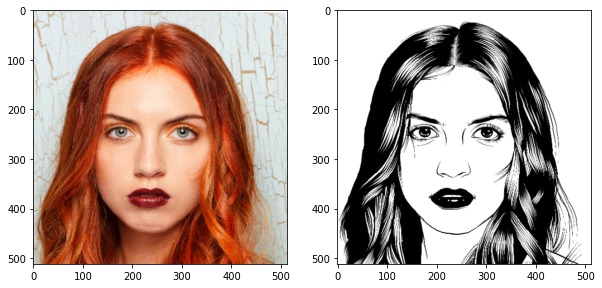

In [ ]:
# Посмотрим на пример из датасета
ind = 3

test_img = test_data['I'][ind].permute(1, 2, 0).numpy()
test_mask = test_data['M'][ind].permute(1, 2, 0).numpy()
print(test_img.shape, test_mask.shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(test_img)
ax[1].imshow(test_mask.squeeze(), plt.cm.gray)
plt.show()

In [ ]:
# Посмотрим нормированы ли даныне
print(np.max(test_img), np.min(test_img))
print(np.max(test_mask), np.min(test_mask))

1.0 0.0
1.0 0.0


In [ ]:
# Зададим на чем обучать сеть
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Создадим класс для тренировки
sketch_trainer = SketchDrawTrainer(dataloaders=dataloaders)

In [ ]:
# Посмотрим на слои сети
sketch_trainer.net

U2NET(
  (stage1): RSU7(
    (rebnconvin): REBNCONV(
      (conv_s1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (rebnconv1): REBNCONV(
      (conv_s1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv2): REBNCONV(
      (conv_s1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv3): REBNCONV(
      (conv_s1): Conv2d(32, 32, k

## Обучение

Epoch 299 / 299, Epoch_acc=0.9441, Historical_best_acc=0.9450 (at epoch 272)



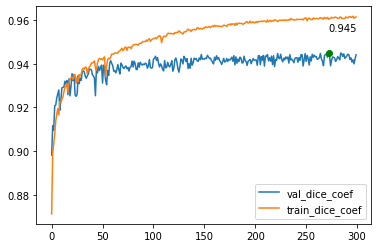

In [ ]:
sketch_trainer.train_models()

### Fine tuning

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
img_size = 512
root_dir = '/content/APDrawingDB/APDrawingDB/'
batch_size = 1
checkpoint_dir = '/content/drive/MyDrive/U2Net_current/advanced_augm/checkpoint/'
vis_dir = '/content/drive/MyDrive/U2Net_current/advanced_augm/results/'
startpoints_set = [[[50,0], [462,0], [0,512], [512,512]],
                   [[0,0], [512,0], [50,512], [462,512]],
                   [[0,50], [512,0], [0,462], [512,512]],
                   [[0,0], [512,50], [0,512], [512,462]]]
endpoints_set = [[[0,0], [512,0], [0,512], [512,512]],
                   [[0,0], [512,0], [0,512], [512,512]],
                   [[0,0], [512,0], [0,512], [512,512]],
                   [[0,0], [512,0], [0,512], [512,512]]]
lr = 0.0001
epochs = 700

training_set = CustomDataset(
    root_dir=root_dir, img_size=img_size, is_train=True
)

val_set = CustomDataset(
    root_dir=root_dir, img_size=img_size, is_train=False
)

datasets = {'train':training_set, 'val':val_set}
print('ok')
dataloaders = {x: DataLoader(datasets[x], batch_size=batch_size, shuffle=True, num_workers=1)
              for x in ['train', 'val']}

ok


Epoch 626 / 699, Epoch_acc=0.9410, Historical_best_acc=0.9450 (at epoch 272)



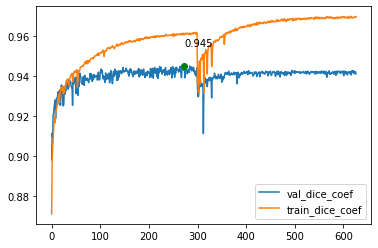

In [ ]:
sketch_trainer = SketchDrawTrainer(dataloaders=dataloaders)
sketch_trainer.train_models()

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

img_size = 512
root_dir = '/content/APDrawingDB/APDrawingDB/'
batch_size = 1
checkpoint_dir = '/content/drive/MyDrive/U2Net_current/advanced_augm/checkpoint/'
vis_dir = '/content/drive/MyDrive/U2Net_current/advanced_augm/results_final/'
startpoints_set = [[[30,0], [482,0], [0,512], [512,512]],
                   [[0,0], [512,0], [30,512], [482,512]],
                   [[0,30], [512,0], [0,482], [512,512]],
                   [[0,0], [512,30], [0,512], [512,482]]]
endpoints_set = [[[0,0], [512,0], [0,512], [512,512]],
                   [[0,0], [512,0], [0,512], [512,512]],
                   [[0,0], [512,0], [0,512], [512,512]],
                   [[0,0], [512,0], [0,512], [512,512]]]
lr = 0.00005
epochs = 1500

training_set = CustomDataset(
    root_dir=root_dir, img_size=img_size, is_train=True
)

val_set = CustomDataset(
    root_dir=root_dir, img_size=img_size, is_train=False
)

datasets = {'train':training_set, 'val':val_set}
print('ok')
dataloaders = {x: DataLoader(datasets[x], batch_size=batch_size, shuffle=True, num_workers=1)
              for x in ['train', 'val']}

ok


Epoch 1426 / 1499, Epoch_acc=0.9418, Historical_best_acc=0.9450 (at epoch 272)



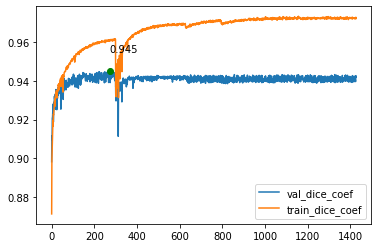

In [ ]:
sketch_trainer = SketchDrawTrainer(dataloaders=dataloaders)
sketch_trainer.train_models()

## Проверка

In [ ]:
def detect_face(face_cascade, img):

  '''
  Input parameters:
    face_cascade - opencv face detector
    img - original image
  Output parameters:
    coordinates of largest face rectangle (format: center_x, center_y, width, height)
  '''

  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  faces = face_cascade.detectMultiScale(gray, 1.1, 4)
  if (len(faces)==0):
    return None
  
  wh = 0
  idx = 0
  for i in range(0,len(faces)):
    (x, y, w, h) = faces[i]
    if (wh < w*h):
      idx = i
      wh = w*h

  return faces[idx]


def crop_face(img, img_size, face=None):

  '''
  Input parameters: 
    img - input image
    img_size - image size for network input
    face - coordinates of face rectangle (format: center_x, center_y, width, height)
  Output parameters:
    cropped_img - image of cropped face with saved aspect ratios in size (img_size, img_size)
  '''

  if (face is None): # If no face coordinates just reshape image with saving aspect ration

    scale = np.min([img_size/(img.shape[0]), img_size/(img.shape[1])])
    new_h, new_w = int((img.shape[0])*scale), int((img.shape[1])*scale)
    face = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_CUBIC)
    cropped_img = np.full((img_size, img_size, 3), 255)
    start_h, end_h = (img_size-new_h)//2, (img_size-new_h)//2 + new_h
    start_w, end_w = (img_size-new_w)//2, (img_size-new_w)//2 + new_w
    cropped_img[start_h:end_h, start_w:end_w, :] = face

    return cropped_img
  
  # Face coordinates
  x, y, w, h = face

  # Cropping face from original image
  top = np.max([y - int(h*0.5), 0])
  bottom = np.min([y + h + int(h*0.3), img.shape[0]])
  left = np.max([x - int(w*0.4), 0])
  right = np.min([x + w + int(w*0.4), img.shape[1]])
  face = img[top:bottom, left:right, :]

  # Reshaping image with saveing sapect ratio
  scale = np.min([img_size/(bottom-top), img_size/(right-left)])
  new_h, new_w = int((bottom-top)*scale), int((right-left)*scale)
  face = cv2.resize(face, (new_w, new_h), interpolation=cv2.INTER_CUBIC)

  # Paste image in (img_size, img_size)
  cropped_img = np.full((img_size, img_size, 3), 255)
  start_h, end_h = (img_size-new_h)//2, (img_size-new_h)//2 + new_h
  start_w, end_w = (img_size-new_w)//2, (img_size-new_w)//2 + new_w

  cropped_img[start_h:end_h, start_w:end_w, :] = face

  return cropped_img

In [ ]:
def predict_img(model, device, face_cascade, filename, img_size):

  '''
  Input parameters:
    model - network model
    device - cpu or gpu if available
    face_cascade - opencv face detector
    filename - path of image for predict
    img_size - network input size
  Output parameters:
    -
  '''

  # Reading image
  img = cv2.imread(filename, cv2.IMREAD_COLOR)

  # Extending channels if image is grayscale
  if len(img.shape) == 2:
    img = img[:,:,np.newaxis]
  if img.shape[2] == 1:
    img = np.stack([img, img, img], axis=1)

  # Image preparation for predict
  face = detect_face(face_cascade, img)
  cropped_img = crop_face(img, img_size, face=face)
  cropped_img = cv2.cvtColor(cropped_img.astype(np.uint8), cv2.COLOR_BGR2RGB)
  cropped_img = cropped_img / 255
  img_for_torch = cropped_img.transpose((2,0,1))[np.newaxis,:,:,:]
  img_for_torch = torch.from_numpy(img_for_torch).type(torch.FloatTensor)
  # Predict
  predict = model(img_for_torch.to(device))[0]
  predict = predict.detach().cpu().numpy().squeeze()

  fig, ax = plt.subplots(1, 2, figsize=(20,8))

  ax[0].imshow(cropped_img)
  ax[0].axis('off')
  ax[1].imshow(predict, plt.cm.gray)
  ax[1].axis('off')

  plt.show()



def draw_sketch(model_path, img_path):

    '''
  Input parameters:
    module_path - directory where sketch drawing module located
    img_path - image for predict directory, including image name
  Output parameters:
    -
  '''

  img_size = 512

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  # Loading net and weights
  model = U2NET(3, 1)
  model.load_state_dict(torch.load(module_path + 'SD_model_dict.pt',  map_location=device))
  model.eval()
  model.to(device)

  face_cascade = cv2.CascadeClassifier(module_path + 'haarcascade_frontalface_default.xml')

  img_dir = predict_img(model, device, face_cascade, img_path, img_size)

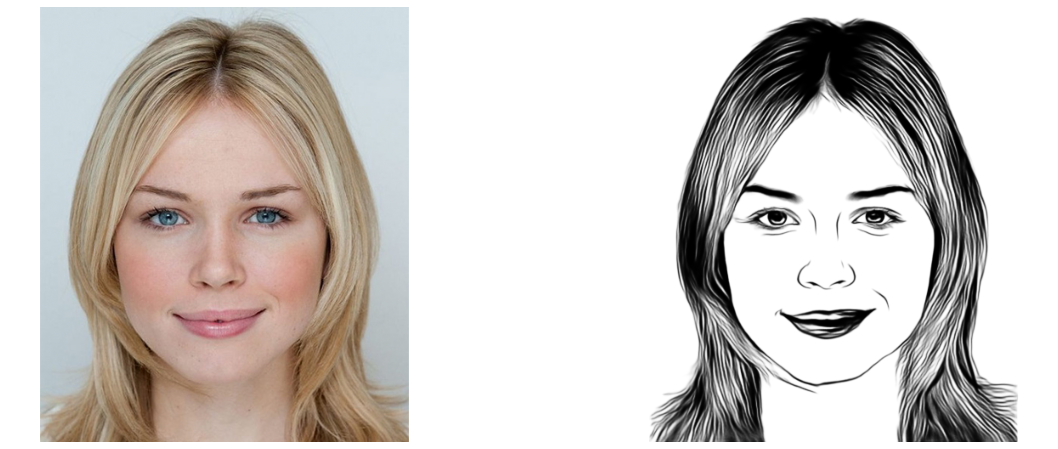

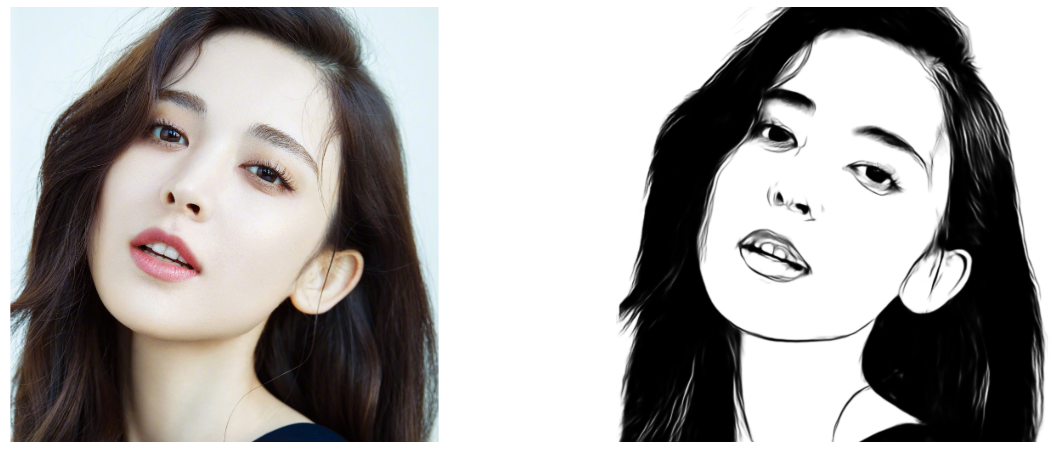

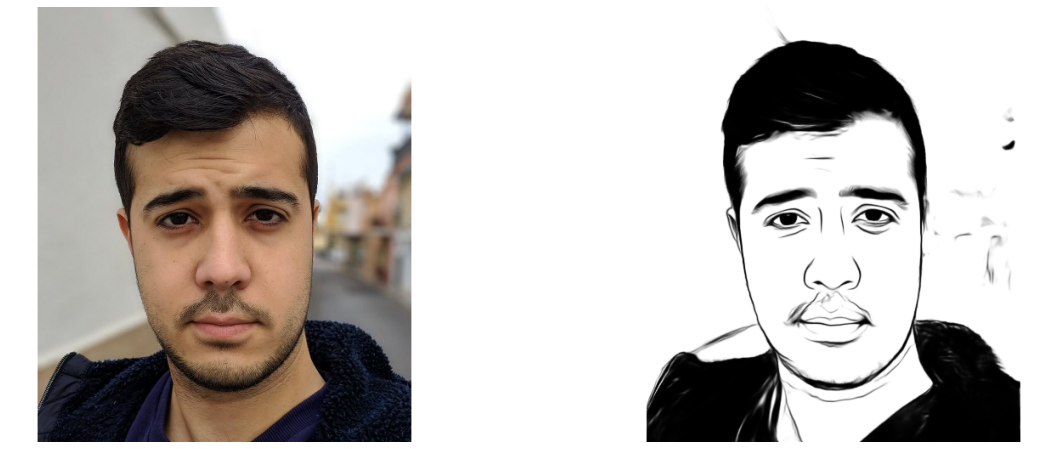

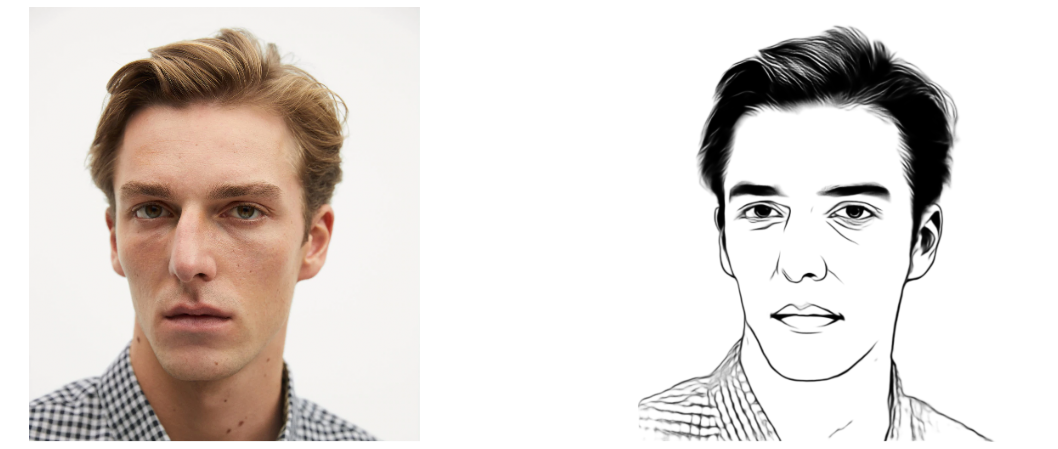

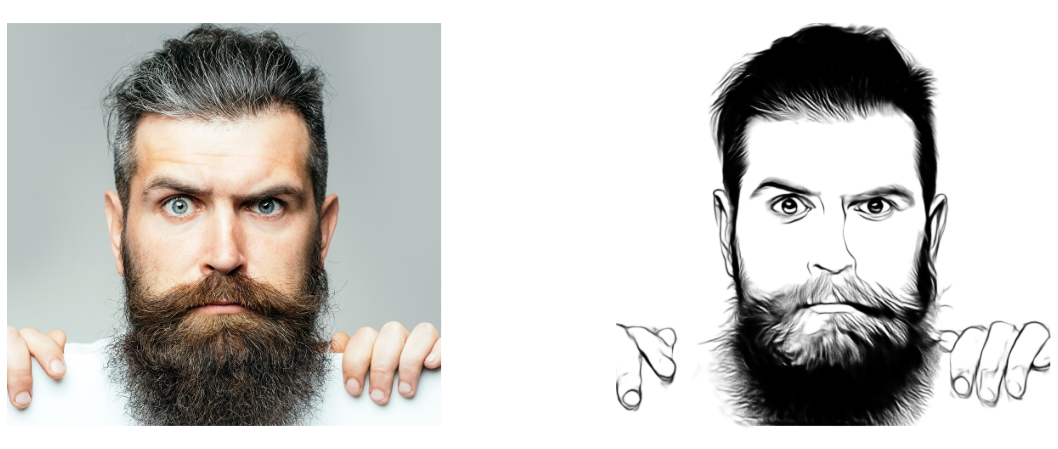

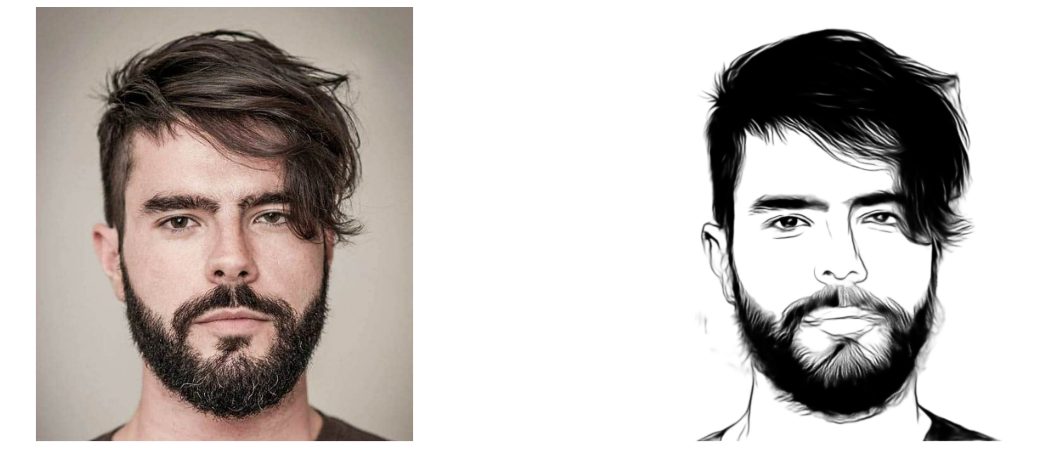

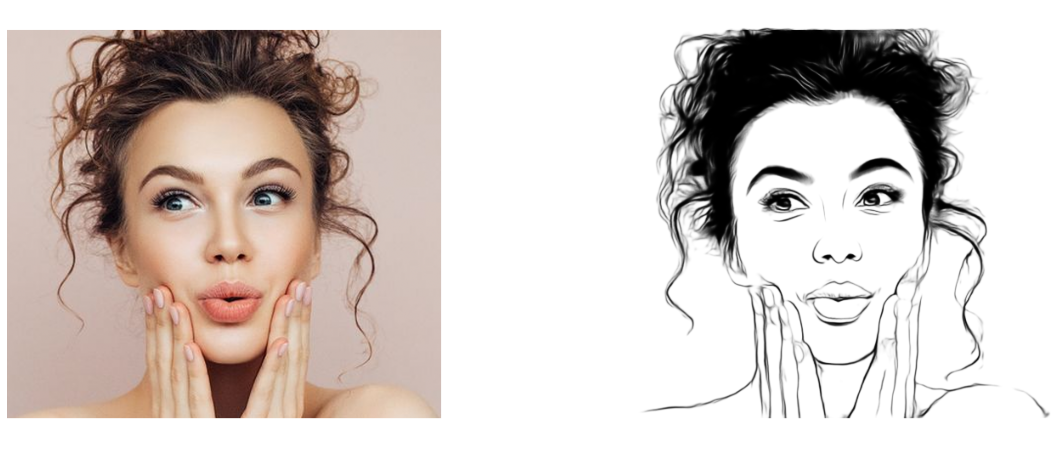

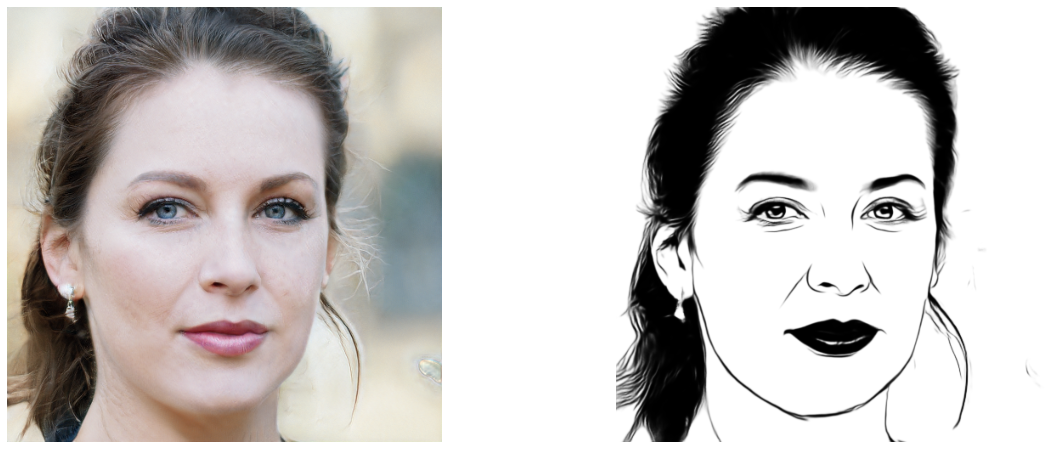

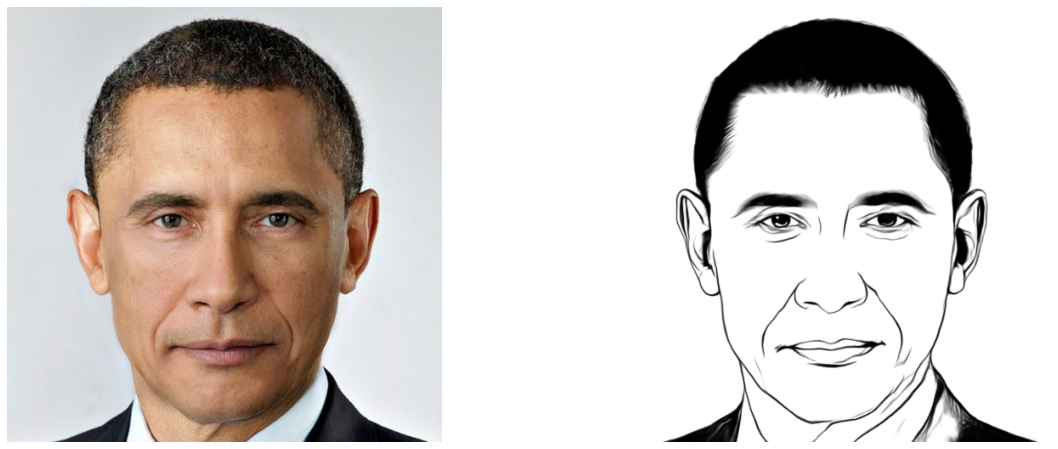

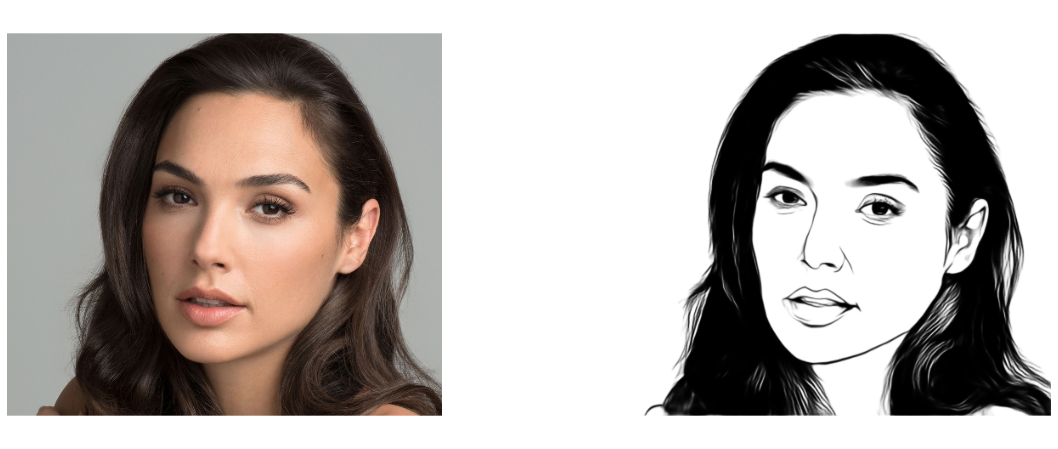

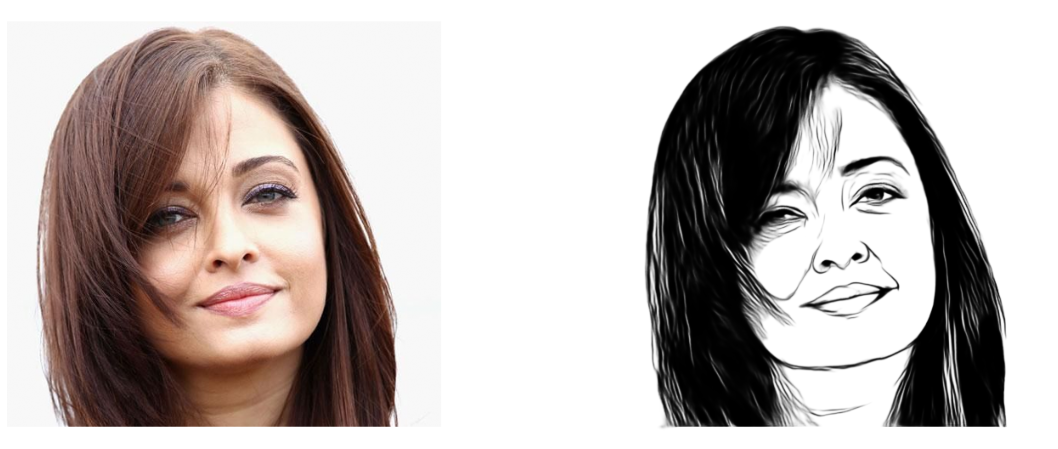

In [ ]:
module_path = '/content/drive/MyDrive/U2Net_current/SD_module/'
img_path = '/content/drive/MyDrive/U2Net_current/SD_module/test_examples/'

for filename in os.listdir(img_path):
  draw_sketch(module_path, img_path+filename)